# Stroke Risk Prediction Model

Goal: Predict the risk of a patient getting a stroke.

Dataset: Contains information about patients, including their age, gender, various health metrics, and whether or not they have had a stroke.

In [844]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

### Data Preprocessing

In [845]:
# Load dataset
stroke_df = pd.read_csv('./dataset/stroke-dataset.csv')

stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [846]:
# Check datatypes of each column
stroke_df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [847]:
# Check for duplicates
stroke_df.duplicated().values.any()

False

In [848]:
# Drop unnecessary columns
print("Columns before drop: ", stroke_df.shape[1])
stroke_df.drop(columns=['id', 'ever_married', 'work_type', 'Residence_type'], inplace=True)
print("Columns after drop: ", stroke_df.shape[1])

Columns before drop:  12
Columns after drop:  8


#### A. Missing Values

In [849]:
# Check for null values 
stroke_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<Axes: >

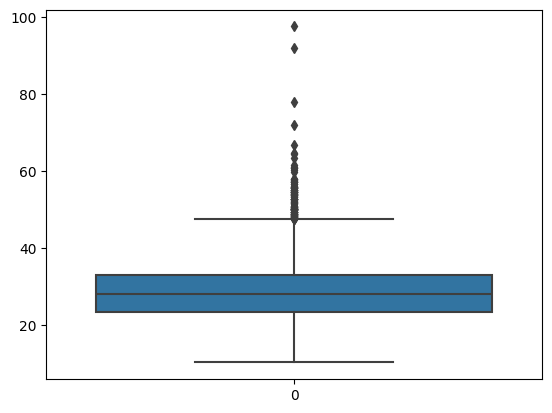

In [850]:
# Visualize BMI
sns.boxplot(stroke_df['bmi'])

In [851]:
# Given that there are many outliers, it is advised to use median instead of mean
stroke_df['bmi'].fillna(stroke_df['bmi'].median(), inplace=True)
print("BMI Median: ", stroke_df['bmi'].median())

# Check for null values again
print("BMI Null Values: ", stroke_df['bmi'].isnull().sum())

BMI Median:  28.1
BMI Null Values:  0


In [852]:
# Check unique values for object datatype columns
print(stroke_df['gender'].unique())
print(stroke_df['smoking_status'].unique())

['Male' 'Female' 'Other']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [853]:
# Replace 'Unknown' in smoking_status with mode
print("Smoking Status Mode: ", stroke_df['smoking_status'].mode()[0])
stroke_df['smoking_status'] = stroke_df['smoking_status'].replace('Unknown', stroke_df['smoking_status'].mode()[0])

# Check unique values for smoking_status again
print(stroke_df['smoking_status'].unique())

Smoking Status Mode:  never smoked
['formerly smoked' 'never smoked' 'smokes']


#### B. Skewness

Note: Will be resolved by StandardScaler, no need to do this

(array([  4.,   9.,  55., 133., 210., 252., 331., 409., 452., 520., 713.,
        402., 370., 304., 221., 182., 129., 112.,  83.,  69.,  33.,  22.,
         25.,  11.,  14.,  14.,  13.,   4.,   4.,   2.,   2.,   1.,   1.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.]),
 array([10.3  , 12.046, 13.792, 15.538, 17.284, 19.03 , 20.776, 22.522,
        24.268, 26.014, 27.76 , 29.506, 31.252, 32.998, 34.744, 36.49 ,
        38.236, 39.982, 41.728, 43.474, 45.22 , 46.966, 48.712, 50.458,
        52.204, 53.95 , 55.696, 57.442, 59.188, 60.934, 62.68 , 64.426,
        66.172, 67.918, 69.664, 71.41 , 73.156, 74.902, 76.648, 78.394,
        80.14 , 81.886, 83.632, 85.378, 87.124, 88.87 , 90.616, 92.362,
        94.108, 95.854, 97.6  ]),
 <BarContainer object of 50 artists>)

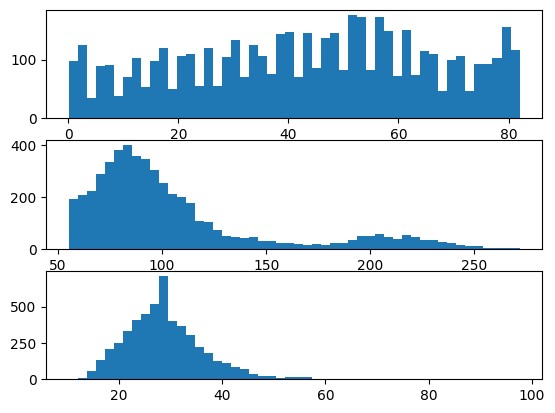

In [854]:
# Display histogram for visualization of all float datatype columns
figure, axis = plt.subplots(3, 1)

axis[0].hist(stroke_df['age'], bins=50)
axis[1].hist(stroke_df['avg_glucose_level'], bins=50)
axis[2].hist(stroke_df['bmi'], bins=50)

In [855]:
# Display skewness
print(stroke_df['age'].skew()) # negative
print(stroke_df['avg_glucose_level'].skew()) # positive
print(stroke_df['bmi'].skew()) # positive

-0.1370593225984694
1.5722838665030459
1.0881872326442346


In [856]:
# Transform using square (for negative) and logarithm (for positive)
def scale(col):
    # Define an acceptable range of skewness (in my case, -0.15 to 0.15)
    while col.skew() <= -0.15 or col.skew() >= 0.15:
        if col.skew() < 0:
            col = np.square(col)
        else:
            col = np.log(col + 1)
    
    return col

# Use function
#stroke_df['age'] = scale(stroke_df['age']) # Note: performing the function on age increases distance from 0, so no need
#stroke_df['avg_glucose_level'] = scale(stroke_df['avg_glucose_level'])
#stroke_df['bmi'] = scale(stroke_df['bmi'])

#### C. Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x247995e6640>,
 'caps': [<matplotlib.lines.Line2D at 0x247995e6b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x247995e63a0>],
 'medians': [<matplotlib.lines.Line2D at 0x247995f4100>],
 'fliers': [<matplotlib.lines.Line2D at 0x247995f43a0>],
 'means': []}

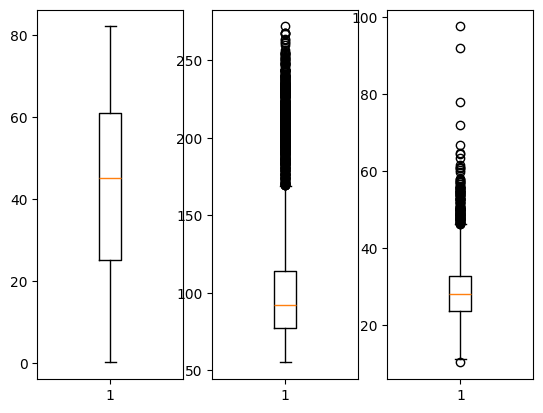

In [857]:
# Display boxplot for visualization of all float datatype columns
figure, axis = plt.subplots(1, 3)

axis[0].boxplot(stroke_df['age'])
axis[1].boxplot(stroke_df['avg_glucose_level'])
axis[2].boxplot(stroke_df['bmi'])

In [858]:
# Remove outliers
def outliers(df, col):
    Q1 = np.percentile(col, 25, method="midpoint")
    Q3 = np.percentile(col, 75, method="midpoint")
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    higher = Q3 + 1.5 * IQR

    return df[(col > lower) & (col < higher)]

# Use function
print(stroke_df.shape[0])
stroke_df = outliers(stroke_df, stroke_df['avg_glucose_level'])
stroke_df = outliers(stroke_df, stroke_df['bmi'])
print(stroke_df.shape[0])

5110
4383


{'whiskers': [<matplotlib.lines.Line2D at 0x2479978ebe0>,
 'caps': [<matplotlib.lines.Line2D at 0x2479979b160>,
 'boxes': [<matplotlib.lines.Line2D at 0x2479978e940>],
 'medians': [<matplotlib.lines.Line2D at 0x2479979b6a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2479979b940>],
 'means': []}

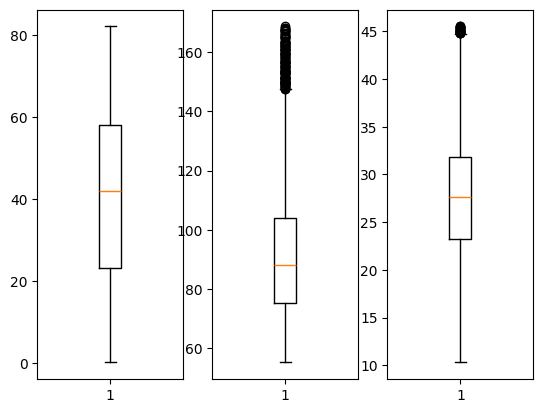

In [859]:
# Display boxplot again to verify outliers were minimized
figure, axis = plt.subplots(1, 3)

axis[0].boxplot(stroke_df['age'])
axis[1].boxplot(stroke_df['avg_glucose_level'])
axis[2].boxplot(stroke_df['bmi'])

#### D. Encoding

In [860]:
# Show unique value counts
print(stroke_df['gender'].value_counts())
print(stroke_df['smoking_status'].value_counts())

gender
Female    2585
Male      1797
Other        1
Name: count, dtype: int64
smoking_status
never smoked       3009
formerly smoked     707
smokes              667
Name: count, dtype: int64


In [861]:
# Convert categorical to numerical
encoder = LabelEncoder()

stroke_df['gender'] = encoder.fit_transform(stroke_df['gender'])
stroke_df['smoking_status'] = encoder.fit_transform(stroke_df['smoking_status'])

In [862]:
# Show unique value counts to check label mapping
print(stroke_df['gender'].value_counts())
print(stroke_df['smoking_status'].value_counts())

gender
0    2585
1    1797
2       1
Name: count, dtype: int64
smoking_status
1    3009
0     707
2     667
Name: count, dtype: int64


In [863]:
# Verify if changes were made
stroke_df.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
2,1,80.0,0,1,105.92,32.5,1,1
6,1,74.0,1,1,70.09,27.4,1,1
7,0,69.0,0,0,94.39,22.8,1,1
8,0,59.0,0,0,76.15,28.1,1,1
9,0,78.0,0,0,58.57,24.2,1,1


### Model Integration

#### A. Dataset Splitting

In [864]:
# Separate into features and target
stroke_features = stroke_df.drop(columns=['stroke'])
stroke_target = stroke_df['stroke']

# Check features
stroke_features

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
2,1,80.0,0,1,105.92,32.5,1
6,1,74.0,1,1,70.09,27.4,1
7,0,69.0,0,0,94.39,22.8,1
8,0,59.0,0,0,76.15,28.1,1
9,0,78.0,0,0,58.57,24.2,1
...,...,...,...,...,...,...,...
5105,0,80.0,1,0,83.75,28.1,1
5106,0,81.0,0,0,125.20,40.0,1
5107,0,35.0,0,0,82.99,30.6,1
5108,1,51.0,0,0,166.29,25.6,0


In [865]:
# Check target
stroke_target

2       1
6       1
7       1
8       1
9       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 4383, dtype: int64

In [866]:
# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    stroke_features.values, stroke_target.values, test_size=0.2, stratify=stroke_target, random_state=14
)

# Check shape
print("x_train: ", x_train.shape, " x_test: ", x_test.shape)
print("x_train: ", x_train.shape, " x_test: ", x_test.shape)

x_train:  (3506, 7)  x_test:  (877, 7)
x_train:  (3506, 7)  x_test:  (877, 7)


#### B. Scaling

In [867]:
# Scale
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Check data
print(x_train[0])

[-0.82165063  0.04131234 -0.27947412 -0.20545475 -0.71894858  1.60250387
  0.01183708]


In [868]:
# Use SMOTE for balancing data
sm = SMOTE(random_state=14)
x_train, y_train = sm.fit_resample(x_train, y_train)

print("smote_features: ", x_train.shape)
print("smote_target: ", y_train.shape)

smote_features:  (6750, 7)
smote_target:  (6750,)


#### C. Training

Algorithm chosen: Decision Tree

In [869]:
# Load model
#model = DecisionTreeClassifier(random_state=100)
model = SVC(random_state=100)
#model = RandomForestClassifier(random_state=100)

# Train model
model.fit(x_train, y_train)

# Test model using X
y_pred = model.predict(x_test)

# Train for prediction probabilities
calibrated_clf = CalibratedClassifierCV(model, method='sigmoid')
calibrated_clf.fit(x_train, y_train)

# Test prediction probabilities using X
proba = calibrated_clf.predict_proba(x_test)

# Evaluate model
model_accuracy = balanced_accuracy_score(y_test, y_pred)
print(model_accuracy)

0.7311862702857963


In [870]:
# Check sample prediction
print(x_test[14])
print(y_pred[14])
print(proba[14])

[-0.82165063  0.70482801 -0.27947412 -0.20545475  1.93853845  1.32328738
 -1.7925451 ]
1
[0.35029655 0.64970345]


#### D. Saving

In [871]:
# Save model
model_filename = "models/stroke_clf.joblib"
calibrated_clf_filename = "models/stroke_calibrated_clf.joblib"
joblib.dump(model, model_filename)
joblib.dump(calibrated_clf, calibrated_clf_filename)

# Save scaler
scaler_filename = "models/scaler.save"
joblib.dump(scaler, scaler_filename)

['models/scaler.save']

In [872]:
# Check model
#sample = np.array([1, 80, 0, 1, 105.92, 32.5, 1]) # Correct
#sample = np.array([1, 74, 1, 1, 70.09, 27.4, 1]) # Wrong
#sample = np.array([0, 69, 0, 0, 94.39, 22.8, 1]) # Correct
#sample = np.array([0, 59, 0, 0, 76.15, 28.1, 1]) # Correct
sample = np.array([0, 78, 0, 0, 58.57, 24.2, 1]) # Correct

sample = scaler.transform(sample.reshape(1, -1))[0]
print(sample)
prediction = model.predict(sample.reshape(1, -1))[0]
print(prediction)
proba = calibrated_clf.predict_proba(sample.reshape(1, -1))[0]
print(proba)

[-0.82165063  1.63374995 -0.27947412 -0.20545475 -1.45814343 -0.53815584
  0.01183708]
1
[0.22816311 0.77183689]


Test data for above:

![Alt text](image.png)